<a href="https://colab.research.google.com/github/Hedsw/ShadowAttack_CNN/blob/main/ShadowAttack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Call Pytorch Library
import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [ ]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
from urllib.request import urlretrieve
import json

# Bring 1000 of Image in Imagenet data
imagenet_json, _ = urlretrieve('http://www.anishathalye.com/media/2017/07/25/imagenet.json')
with open(imagenet_json) as f:
    imagenet_labels = json.load(f)

In [ ]:
print(imagenet_labels[18])

magpie


In [ ]:
imsize = 299
preprocess = transforms.Compose([
    transforms.Resize(imsize), # Image Size Change
    transforms.CenterCrop(imsize), # Image Cut in central part
    transforms.ToTensor(), # torch.Tensor  [0, 255] → [0, 1]
])

In [ ]:
import matplotlib.pyplot as plt
import PIL

In [ ]:
def image_loader(path):
    image = PIL.Image.open(path)
    image = preprocess(image).unsqueeze(0)
    return image.to(device, torch.float) # Put on the data into GPU

In [ ]:
url = "http://www.image-net.org/nodes/10/02123045/6c/6c34fe7c9d846c33a2f1a9b47a766b44ab4ec70d.thumb"
image_path, _ = urlretrieve(url)
image = image_loader(image_path)
# Call Cat Image

In [ ]:
def imshow(tensor):
    image = tensor.cpu().clone()
    # torch.Tensor Dimension Eliminate
    image = image.squeeze(0)
    # PIL Object Change
    image = transforms.ToPILImage()(image)
    # Print out the Image
    plt.imshow(image)

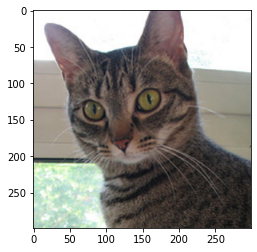

In [ ]:
plt.figure()
imshow(image)

In [ ]:
class Normalize(nn.Module) :
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [ ]:
model = nn.Sequential(
    # Add Inception v3 same action with regular Layer
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True)
).to(device).eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [ ]:
outputs = model(image)
# Use Softmax 
percentages = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
# Top 5 Index 
print("< Top 5 High-Percentage Classes >")
for i in outputs[0].topk(5)[1]:
    print(f"Index: {i.item()} / Class Name: {imagenet_labels[i]} / Percentage: {round(percentages[i].item(), 4)}%")

< Top 5 High-Percentage Classes >
Index: 285 / Class Name: Egyptian cat / Percentage: 45.5017%
Index: 281 / Class Name: tabby, tabby cat / Percentage: 35.9671%
Index: 282 / Class Name: tiger cat / Percentage: 14.1485%
Index: 840 / Class Name: swab, swob, mop / Percentage: 0.1396%
Index: 478 / Class Name: carton / Percentage: 0.0678%


In [ ]:
def _tv_diff(channel):
    x_wise = channel[:, :, 1:] - channel[:, :, :-1]
    y_wise = channel[:, 1:, :] - channel[:, :-1, :]
    return x_wise, y_wise

def smooth_tv(channel) -> torch.Tensor:
    x_wise, y_wise = _tv_diff(channel)
    return (x_wise * x_wise).sum() + (y_wise * y_wise).sum()

def get_tv(input: torch.Tensor) -> torch.Tensor:
    return smooth_tv(input[:, 0]) + smooth_tv(input[:, 1]) + smooth_tv(input[:, 2])

def get_ct(input):
    return input.repeat((1, 3, 1, 1))

In [ ]:
def shadow_attack_Linf(model, images, labels, targeted, eps, alpha, iters):
    images = images.to(device)
    labels = labels.to(device)
    perturbation = torch.empty_like(images[:, :1, :, :]).uniform_(-eps, eps)
    perturbation.to(device)
    attack_loss = nn.CrossEntropyLoss()

    for i in range(iters):
        perturbation.requires_grad = True
        ct = get_ct(perturbation)

        current = torch.clamp(images + ct, min=0, max=1)
        outputs = model(current)

        model.zero_grad()
        cost = attack_loss(outputs, labels).to(device)
        cost += get_tv(ct) * 0.01 
        cost += ct.norm(p=2) * 0.000001 
        cost.backward()

        if targeted: 
            diff = -alpha * perturbation.grad.sign()
        else:
            diff = alpha * perturbation.grad.sign()
        perturbation = torch.clamp(perturbation + diff, min=-eps, max=eps).detach_() 

    current = torch.clamp(images + perturbation, min=0, max=1)
    return current, get_ct(perturbation)

In [ ]:
targeted = True
eps = 8/255 
alpha = 1/255
iters = 200
label = [18]
label = torch.Tensor(label)
label = label.type(torch.long)
adv_image, perturbation = shadow_attack_Linf(model, image, label, targeted, eps, alpha, iters)

In [ ]:
outputs = model(adv_image)
percentages = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
print("< Top 5 High-percentage Classes >")
for i in outputs[0].topk(5)[1]:
    print(f"Index: {i.item()} / Class Name: {imagenet_labels[i]} / Percentage: {round(percentages[i].item(), 4)}%")

< Top 5 High-percentage Classes >
Index: 18 / Class Name: magpie / Percentage: 73.1355%
Index: 285 / Class Name: Egyptian cat / Percentage: 8.9063%
Index: 281 / Class Name: tabby, tabby cat / Percentage: 2.0668%
Index: 463 / Class Name: bucket, pail / Percentage: 1.5549%
Index: 17 / Class Name: jay / Percentage: 0.7155%
